This notebook covers the basics of operations on Series and DataFrames. Again, a quick check on whether you know the material.

1. Can you use numpy ufuncs (e.g. `np.exp`) on DataFrames?
2. What happens when you add two DataFrames with different indicies?

If you know the answers already, you can skip to our first [application](#Application:-Economic-Timeseries). Maybe download some additional datasets from [FRED](https://research.stlouisfed.org) and play with those; try to figure out how to fix the economy. You've got about 5 minutes.

`DataFrame`s and `Series` support all the usual math operations. Additionally,
numpy [`ufuncs`](http://docs.scipy.org/doc/numpy/reference/ufuncs.html) (e.g. `np.log`) can  be used as expected.

In [1]:
import numpy as np
import pandas as pd

# `ufuncs` 

In [2]:
np.random.seed(42)
df = pd.DataFrame(np.random.uniform(0, 10, size=(3, 3)))
df

0         1         2
0  3.745401  9.507143  7.319939
1  5.986585  1.560186  1.559945
2  0.580836  8.661761  6.011150

In [3]:
df + 1

0          1         2
0  4.745401  10.507143  8.319939
1  6.986585   2.560186  2.559945
2  1.580836   9.661761  7.011150

In [4]:
df ** 2

0          1          2
0  14.028030  90.385769  53.581513
1  35.839198   2.434182   2.433429
2   0.337371  75.026112  36.133926

In [5]:
np.log(df)

0         1         2
0  1.320529  2.252043  1.990602
1  1.789521  0.444805  0.444651
2 -0.543287  2.158918  1.793616

# Alignment

But we don't just have NumPy arrays. We have `DataFrames` and `Series`, which have *labels*.
Pandas automatically aligns by label when doing operations between `DataFrames` and `Series`.

In [6]:
df1 = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})
df2 = pd.DataFrame({'A': [2, 4, 6], 'B': [1, 4, 9]})

df1

A  B
0  1  4
1  2  5
2  3  6

In [7]:
df2

A  B
0  2  1
1  4  4
2  6  9

In [8]:
df1 + df2

A   B
0  3   5
1  6   9
2  9  15

In [9]:
# Note the index order
df2 = pd.DataFrame({'A': [6, 2, 4], 'B': [9, 1, 4]}, index=[2, 0, 1])
df2

A  B
2  6  9
0  2  1
1  4  4

In [10]:
df1 + df2

A   B
0  3   5
1  6   9
2  9  15

In [11]:
# Different index entirely
df3 = pd.DataFrame(np.random.randn(5, 3), columns=['A', 'B', 'C'])
df3

A         B         C
0 -0.580878 -0.525170 -0.571380
1 -0.924083 -2.612549  0.950370
2  0.816445 -1.523876 -0.428046
3 -0.742407 -0.703344 -2.139621
4 -0.629475  0.597720  2.559488

In [12]:
df1 + df3

A         B   C
0  0.419122  3.474830 NaN
1  1.075917  2.387451 NaN
2  3.816445  4.476124 NaN
3       NaN       NaN NaN
4       NaN       NaN NaN

# Recap

- `ufuncs` work just fine
- broadcasting works fine
- Operations **align by label** and then are performed

# Application: Economic Timeseries

In [13]:
from itertools import chain

import pandas as pd

import seaborn as sns
import statsmodels.api as sm
# from pandas_datareader import data
# from pandas.io import data
import matplotlib.pyplot as plt
from toolz import partitionby

%matplotlib inline
pd.options.display.max_rows = 10
sns.set_style('ticks')

Pandas recently split off some web-based data reading functionality into its own package `pandas-datareader`. Earlier, I used it to grab data from [FRED](http://research.stlouisfed.org).

```python
gdp = data.DataReader("GDP", data_source='fred', start='1929', end='2014').squeeze()
cpi = data.DataReader("CPIAUCSL", data_source='fred', start='1947-01', end='2015-05').squeeze()
rec = data.DataReader('USREC', data_source='fred', start='1854-12-01', end='2014-08-01').squeeze()
gdp.to_csv('data/gdp.csv', header=True)
cpi.to_csv('data/cpi.csv', header=True)
rec.to_csv('data/rec.csv', header=True)
```

In [14]:
!head data/gdp.csv

DATE,GDP
1947-01-01,243.1
1947-04-01,246.3
1947-07-01,250.1
1947-10-01,260.3
1948-01-01,266.2
1948-04-01,272.9
1948-07-01,279.5
1948-10-01,280.7
1949-01-01,275.4


In [15]:
pd.read_csv?

In [16]:
gdp = pd.read_csv('data/gdp.csv', index_col='DATE', parse_dates=['DATE']).squeeze()
cpi = pd.read_csv('data/cpi.csv', index_col='DATE', parse_dates=['DATE']).squeeze()
rec = pd.read_csv('data/rec.csv', index_col='DATE', parse_dates=['DATE']).squeeze()

In [17]:
gdp.head(n=5)

DATE
1947-01-01    243.1
1947-04-01    246.3
1947-07-01    250.1
1947-10-01    260.3
1948-01-01    266.2
Name: GDP, dtype: float64

In [18]:
cpi.head()

DATE
1947-01-01    21.48
1947-02-01    21.62
1947-03-01    22.00
1947-04-01    22.00
1947-05-01    21.95
Name: CPIAUCSL, dtype: float64

In [19]:
rec.head()

DATE
1854-12-01    1
1855-01-01    0
1855-02-01    0
1855-03-01    0
1855-04-01    0
Name: USREC, dtype: int64

# Table Summarization

Pandas has a few methods for summarizing the contents of a DataFrame or Series

In [20]:
gdp.describe()

count      269.000000
mean      5074.190335
std       5158.153013
min        243.100000
25%        654.800000
50%       2860.000000
75%       8551.900000
max      17078.300000
Name: GDP, dtype: float64

`describe` actually combines and few different *aggregation* methods that summarise a DataFrame or Series. These include `mean`, `max`, `std`, `quantile`...

In [21]:
print('mean:    ', gdp.mean())
print('std:     ', gdp.std())
print('quantile:', gdp.quantile(.66))
print('max:     ', gdp.max())

mean:     5074.1903345724895
std:      5158.153012839137
quantile: 6132.956
max:      17078.3


It can also be useful to get the argmax, or the index label where the maximum occurs.

In [22]:
gdp.idxmax()

Timestamp('2013-10-01 00:00:00')

# Plotting

DataFrames and Series can make decent looking plots with a few lines of code.

I wanted to incude bars for recession indicators.
The only pandas-relavent bit is `Series.iteritems`, which you *almost* never want to use since it's relatively slow.

In [23]:
next(rec.iteritems())  

(Timestamp('1854-12-01 00:00:00'), 1)

In [24]:
groups = partitionby(lambda x: x[1] == 1, rec.iteritems())
recessions = filter(lambda x: x[0][1] == 1, groups)
spans = [(months[0][0], months[-1][0]) for months in recessions]

In [25]:
def add_rec_bars(ax=None):
    ax = ax or plt.gca()
    for span in spans:
        ax.fill_between(span, *ax.get_ylim(), color='k', alpha=.25)
    return ax

plt.rcParams['figure.figsize'] = (12, 6)

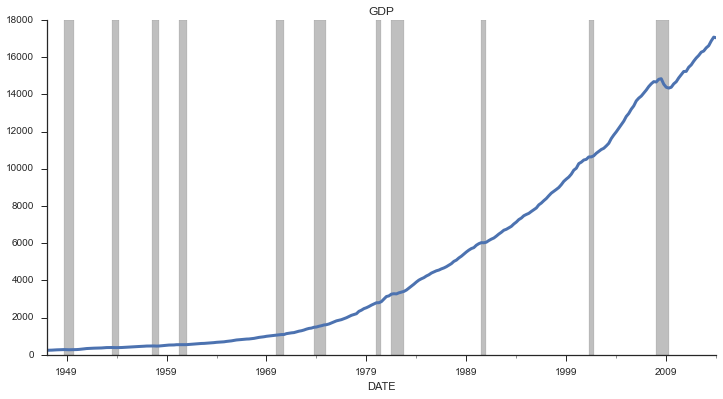

In [26]:
ax = gdp.plot(title='GDP', linewidth=3)
add_rec_bars(ax)
sns.despine()

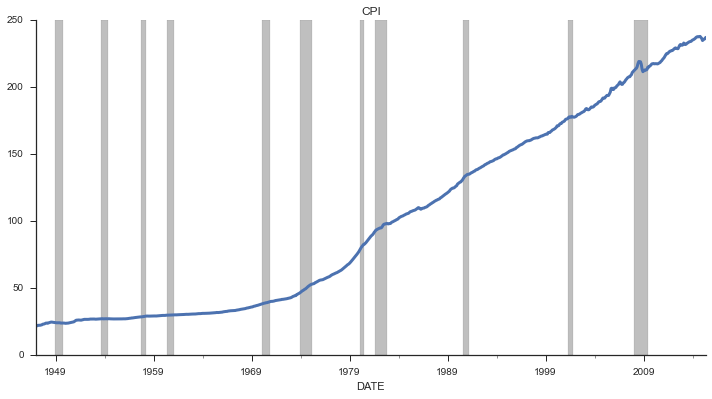

In [27]:
ax = cpi.plot(title='CPI', linewidth=3)
add_rec_bars(ax)
sns.despine()

Let's put some of those operations to use.

# Execrise: Convert CPI to be base 2009

CPI is the Consumer Price Index. The Index part just means that it doesn't really have any units,
just some (arbitrary) time span that is set to 100, and every other observation is relative to that time.
The CPI we have is based on 1982-1984.

**Convert the CPI base-2009 by dividing the entire Series `cpi` by the average CPI in 2009.**

Try breaking the problem into pieces:
1. Select just the rows from 2009 (`.loc`)
  + Timeseries (dates in the index) have speical rules for slicing. Pass in a string with the subset you want
    + `.loc['2010-01-01']` select all observations from that day
    + `.loc['2010-01']` selects all observations from that month
2. calculate the average on those rows
3. divide `cpi` by that number (assign that to `cpi09`)

In [28]:
# Your code goes here
# Assign the result to cpi09

In [31]:
%load -r 1:5 solutions_operations.py

DATE
1947-01-01    0.100110
1947-02-01    0.100762
1947-03-01    0.102533
1947-04-01    0.102533
1947-05-01    0.102300
                ...   
2015-01-01    1.093736
2015-02-01    1.096108
2015-03-01    1.098690
2015-04-01    1.099818
2015-05-01    1.104707
Name: CPIAUCSL, dtype: float64

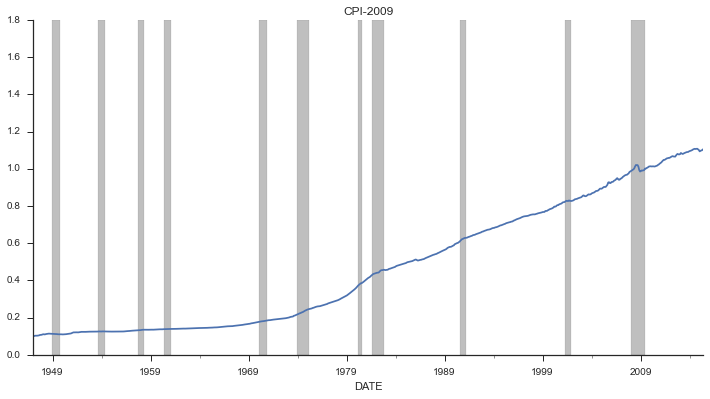

In [32]:
ax = cpi09.plot(title='CPI-2009')
add_rec_bars(ax=ax)
sns.despine();

# Real GDP: Alignment

Let's say we want real GDP (adjusted for inflation).

\begin{equation}
    rGDP_t = \frac{GDP_t}{CPI_t}
\end{equation}

Problem: our CPI is monthly but GDP is quarterly. Also the two Series have different start and end points. If you didn't have automatic label alignment, you'd have to jump through hoops to select the correct subset of each series.


```python
# this is boolean indexing, we'll see more later
gdp / cpi09[(cpi.index.month % 3 == 1) & (cpi09.index.year <= 2014)]
```

... but that's unneccesary. The operations will automatically align for you.

In [33]:
rgdp = (gdp / cpi09)
rgdp

DATE
1947-01-01    2428.336614
1947-02-01            NaN
1947-03-01            NaN
1947-04-01    2402.148973
1947-05-01            NaN
                 ...     
2015-01-01            NaN
2015-02-01            NaN
2015-03-01            NaN
2015-04-01            NaN
2015-05-01            NaN
dtype: float64

The `NaN`s are missing value indicators. `NaN`s can crop up for many reasons, but in this case it's because the labels didn't overlap perfectly.

Many pandas methods, e.g. aggregations like `sum` or `mean`, will ignore missing values.
Pandas provides methods for detetcing missing data `.isnull`, filling missing data `.fillna`,
or you can dropping it, which is what I'll do here.

In [36]:
rgdp.dropna()

DATE
1947-01-01     2428.336614
1947-04-01     2402.148973
1947-07-01     2413.973150
1947-10-01     2437.851712
1948-01-01     2412.040298
                  ...     
2013-01-01    15298.871240
2013-04-01    15391.990004
2013-07-01    15538.670381
2013-10-01    15666.322137
2014-01-01    15553.401461
dtype: float64

Pandas methods are non-mutating by default. This means that even though I called `.dropna()` above, `rgdp` still has missing values.

In [41]:
rgdp

DATE
1947-01-01    2428.336614
1947-02-01            NaN
1947-03-01            NaN
1947-04-01    2402.148973
1947-05-01            NaN
                 ...     
2015-01-01            NaN
2015-02-01            NaN
2015-03-01            NaN
2015-04-01            NaN
2015-05-01            NaN
dtype: float64

To capture the change, assign a name to the result. In this case, I just the same name `rgdp`.

In [42]:
rgdp = rgdp.dropna()
rgdp.head()

DATE
1947-01-01    2428.336614
1947-04-01    2402.148973
1947-07-01    2413.973150
1947-10-01    2437.851712
1948-01-01    2412.040298
dtype: float64

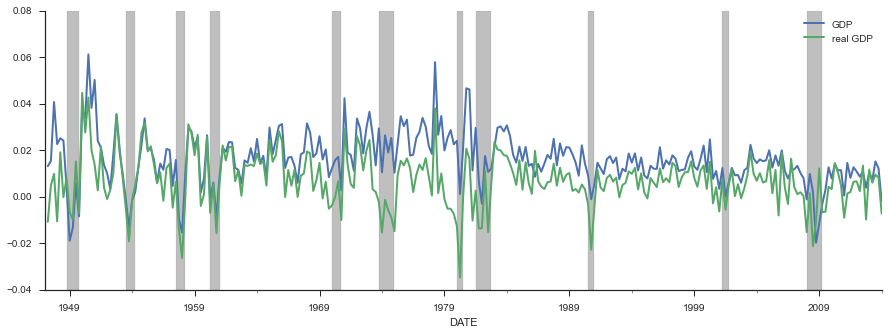

In [43]:
ax = gdp.pct_change().plot(figsize=(15, 5), label='GDP', legend=True, linewidth=2)
rgdp.pct_change().plot(ax=ax, label='real GDP', legend=True, linewidth=2)
add_rec_bars(ax)
sns.despine()

# Recap

DataFrames allow you to rapidly explore data, iterating on ideas.

- `ufunc`s work as expected
- operations between pandas objects automatically align on labels